In [1]:
##########################################################################
## This script visualizes the distributions of the three indices
##########################################################################

In [2]:
# import modules
import ot
import numpy as np
import pandas as pd
import seaborn as sns
import pickle, time, scipy, operator
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy import interp
from scipy.ndimage import filters
from scipy.stats import norm
from sklearn import tree
from sklearn.linear_model import LinearRegression
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.patches import Ellipse
from IPython import display
from scipy.stats import gaussian_kde
#import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
# function definitions
def Gini_idx(X):
    """
    X: sorted income array
    """
    X = np.sort(X)
    sum_income = np.sum(X)
    prop_income = np.cumsum(X) / sum_income
    prop_ideal = np.arange(1, len(X)+1) / (len(X))
    res_Gini = 1 - np.mean(prop_income) / np.mean(prop_ideal)
    return res_Gini

def median_wage(X):
    """
    X: sorted income array
    """
    return np.median(X)

def poverty_rate(X):
    """
    X: sorted income array
    """
    pvt_rt = np.sum(X < 12760) / len(X)
    return pvt_rt

In [4]:
# load data
## load ground truth
Y = pd.read_csv('../../data/income/processed/dat_Y.csv').to_numpy()
## load quantile predictions
Y_test_WDL = pd.read_csv('predictions/qt_test_WDL.csv', index_col=0).to_numpy()
Y_test_Frechet = pd.read_csv('predictions/qt_test_Frechet.csv', index_col=0).to_numpy()
Y_test_CLR = pd.read_csv('predictions/qt_test_CLR.csv', index_col=0).to_numpy()
## load scalar prediction of indices
indices_test_linear = pd.read_csv('predictions/pred_linear.csv', index_col=0).to_numpy()
indices_test_tree = pd.read_csv('predictions/pred_tree.csv', index_col=0).to_numpy()
## transform data
n_dist = Y.shape[0]
n_levs = 99
q_vec = np.arange(1, (n_levs+1)) / (n_levs+1)
## transform Y
Q_mat = np.array([np.quantile(Y[i], q_vec) for i in range(n_dist)])

In [5]:
# create indices
indices_ = []
indices_test_WDL = []
indices_test_Frechet = []
indices_test_CLR = []
for i in range(Y.shape[0]):
    incomes_ = np.exp(Q_mat[i]) 
    indices_.append([Gini_idx(incomes_), median_wage(incomes_), poverty_rate(incomes_)])
    incomes_ = np.exp(Y_test_WDL[i]) ## take exponential
    indices_test_WDL.append([Gini_idx(incomes_), median_wage(incomes_), poverty_rate(incomes_)])
    incomes_ = np.exp(Y_test_Frechet[i]) 
    indices_test_Frechet.append([Gini_idx(incomes_), median_wage(incomes_), poverty_rate(incomes_)])
    incomes_ = np.exp(Y_test_CLR[i]) 
    indices_test_CLR.append([Gini_idx(incomes_), median_wage(incomes_), poverty_rate(incomes_)])
indices_ = np.array(indices_)
indices_test_WDL = np.array(indices_test_WDL)
indices_test_Frechet = np.array(indices_test_Frechet)
indices_test_CLR = np.array(indices_test_CLR)

In [6]:
# load predictions on training set
loc_cv = pd.read_csv('../../data/income/processed/dat_CV.csv').to_numpy().flatten()
indices_train_linear = np.load('predictions/train_linear.npy')
indices_train_tree = np.load('predictions/train_tree.npy')

In [7]:
num_sample = 100
indices_linear = []
indices_tree = []
for i in range(indices_.shape[0]):
    id_cv = loc_cv[i]
    res_mat_linear = indices_[loc_cv != id_cv] - indices_train_linear[loc_cv != id_cv, :, id_cv]
    res_mat_linear = res_mat_linear - np.mean(res_mat_linear, axis=0)
    row_sample = np.random.choice(res_mat_linear.shape[0], size=num_sample)
    noise_mat_linear = res_mat_linear[row_sample]
    indices_linear = indices_linear + list(noise_mat_linear + indices_test_linear[i])
    
    res_mat_tree = indices_[loc_cv != id_cv] - indices_train_tree[loc_cv != id_cv, :, id_cv]
    res_mat_tree = res_mat_tree - np.mean(res_mat_tree, axis=0)
    row_sample = np.random.choice(res_mat_tree.shape[0], size=num_sample)
    noise_mat_tree = res_mat_tree[row_sample]
    indices_tree = indices_tree + list(noise_mat_tree + indices_test_tree[i])
indices_linear = np.array(indices_linear)
indices_tree = np.array(indices_tree)

In [8]:
Q_train_WDL = np.load('predictions/qt_train_WDL.npy')
Q_WDL = []
for i in range(indices_.shape[0]):
    id_cv = loc_cv[i]
    res_mat_WDL = Q_mat[loc_cv != id_cv] - Q_train_WDL[loc_cv != id_cv, :, id_cv]
    loc_sample = np.random.choice(res_mat_WDL.shape[0], size=num_sample)
    Q_WDL = Q_WDL + list(Y_test_WDL[i] + res_mat_WDL[loc_sample])
Q_WDL = np.array(Q_WDL)
indices_WDL = []
for i in range(Q_WDL.shape[0]):
    incomes_ = np.exp(Q_WDL[i]) ## take exponential
    indices_WDL.append([Gini_idx(incomes_), median_wage(incomes_), poverty_rate(incomes_)])
indices_WDL = np.array(indices_WDL)

In [9]:
## sum of Wasserstein distances between the joint distributions of 2D-indices
import scipy.stats as ss

ind_gt = np.array(ss.zscore(indices_))
ind_WDL = np.array(ss.zscore(indices_WDL))
#ind_Frechet = np.array(ss.zscore(indices_Frechet))
#ind_CLR = np.array(ss.zscore(indices_CLR))
ind_linear = np.array(ss.zscore(indices_linear))
ind_tree = np.array(ss.zscore(indices_tree))

n = ind_gt.shape[0]
a = np.ones((n,)) / n
b = np.ones((n*num_sample,)) / (n*num_sample)# uniform distribution on samples

dist_WDL_1 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 2)], ind_WDL[:, (0, 2)], a, b, 1000, 2021)
dist_WDL_2 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 1)], ind_WDL[:, (0, 1)], a, b, 1000, 2021)
dist_WDL_3 = ot.sliced_wasserstein_distance(ind_gt[:, (1, 2)], ind_WDL[:, (1, 2)], a, b, 1000, 2021)
dist_WDL = dist_WDL_1 + dist_WDL_2 + dist_WDL_3

'''
dist_Frechet_1 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 2)], ind_Frechet[:, (0, 2)], a, b, 1000, 2021)
dist_Frechet_2 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 1)], ind_Frechet[:, (0, 1)], a, b, 1000, 2021)
dist_Frechet_3 = ot.sliced_wasserstein_distance(ind_gt[:, (1, 2)], ind_Frechet[:, (1, 2)], a, b, 1000, 2021)
dist_Frechet = dist_Frechet_1 + dist_Frechet_2 + dist_Frechet_3

dist_CLR_1 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 2)], ind_CLR[:, (0, 2)], a, b, 1000, 2021)
dist_CLR_2 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 1)], ind_CLR[:, (0, 1)], a, b, 1000, 2021)
dist_CLR_3 = ot.sliced_wasserstein_distance(ind_gt[:, (1, 2)], ind_CLR[:, (1, 2)], a, b, 1000, 2021)
dist_CLR = dist_CLR_1 + dist_CLR_2 + dist_CLR_3
'''

dist_linear_1 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 2)], ind_linear[:, (0, 2)], a, b, 1000, 2021)
dist_linear_2 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 1)], ind_linear[:, (0, 1)], a, b, 1000, 2021)
dist_linear_3 = ot.sliced_wasserstein_distance(ind_gt[:, (1, 2)], ind_linear[:, (1, 2)], a, b, 1000, 2021)
dist_linear = dist_linear_1 + dist_linear_2 + dist_linear_3

dist_tree_1 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 2)], ind_tree[:, (0, 2)], a, b, 1000, 2021)
dist_tree_2 = ot.sliced_wasserstein_distance(ind_gt[:, (0, 1)], ind_tree[:, (0, 1)], a, b, 1000, 2021)
dist_tree_3 = ot.sliced_wasserstein_distance(ind_gt[:, (1, 2)], ind_tree[:, (1, 2)], a, b, 1000, 2021)
dist_tree = dist_tree_1 + dist_tree_2 + dist_tree_3

print('WDL', dist_WDL)
#print('Frechet', dist_Frechet)
#print('CLR', dist_CLR)
print('Linear', dist_linear)
print('Tree', dist_tree)

WDL 0.40415515812229486
Linear 0.5983461874573822
Tree 0.3411732249873321


Start: 2021-09-14 23:52:31.920926


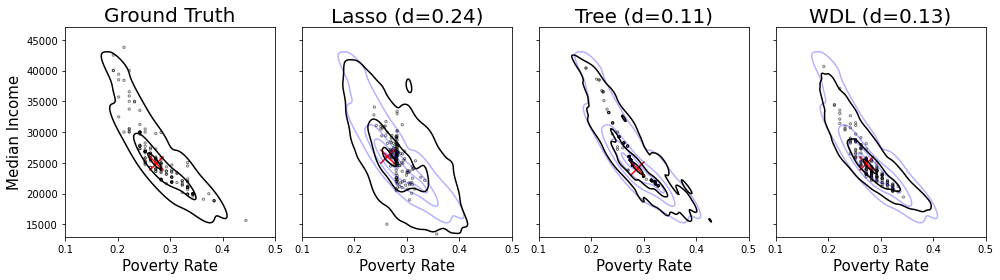

Total: 0:00:39.739773


In [10]:
## visualize the predicted mu and sigma
time_start = datetime.now()
print('Start:', time_start)
fig, ax = plt.subplots(1, 4, figsize=(14, 4))
size_mode = 200
alpha_scatter = 0.5
# axis: 0-Gini , 1-Median, 2-poverty
ax[0].scatter(indices_[:, 2], indices_[:, 1], s=5, facecolors='none', edgecolors='black', alpha=alpha_scatter)
df = pd.DataFrame({'X': indices_[:, 2], 'Y': indices_[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='black', levels=[0.05, 0.5, 0.95], ax=ax[0])
kde = gaussian_kde(df.T, bw_method='scott')
dat_mode = df.iloc[np.argmax(kde.evaluate(df.T))]
ax[0].scatter(dat_mode['X'], dat_mode['Y'], marker='x', color='red', s=size_mode)
ax[0].set_xlabel('Poverty Rate', fontsize=15)
ax[0].set_ylabel('Median Income', fontsize=15)
ax[0].set_xlim([0.1, 0.5])
ax[0].set_ylim([13000, 47000])
ax[0].set_title('Ground Truth', fontsize=20)

ax[1].scatter(indices_test_linear[:, 2], indices_test_linear[:, 1], s=5, facecolors='none', edgecolors='black', alpha=alpha_scatter)
df = pd.DataFrame({'X': indices_[:, 2], 'Y': indices_[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='blue', levels=[0.05, 0.35, 0.65, 0.95], ax=ax[1], alpha=0.3)
df = pd.DataFrame({'X':indices_linear[:, 2], 'Y': indices_linear[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='black', levels=[0.05, 0.5, 0.95], ax=ax[1])
kde = gaussian_kde(df.T, bw_method='scott')
dat_mode = df.iloc[np.argmax(kde.evaluate(df.T))]
ax[1].scatter(dat_mode['X'], dat_mode['Y'], marker='x', color='red', s=size_mode)
ax[1].set_xlabel('Poverty Rate', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].set_xlim([0.1, 0.5])
ax[1].set_ylim([13000, 47000])
ax[1].set_title('Lasso (d='+str(round(dist_linear_3, 2))+')', fontsize=20)


ax[2].scatter(indices_test_tree[:, 2], indices_test_tree[:, 1], s=5, facecolors='none', edgecolors='black', alpha=alpha_scatter)
df = pd.DataFrame({'X': indices_[:, 2], 'Y': indices_[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='blue', levels=[0.05, 0.35, 0.65, 0.95], ax=ax[2], alpha=0.3)
df = pd.DataFrame({'X':indices_tree[:, 2], 'Y': indices_tree[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='black', levels=[0.05, 0.5, 0.95], ax=ax[2])
kde = gaussian_kde(df.T, bw_method='scott')
dat_mode = df.iloc[np.argmax(kde.evaluate(df.T))]
ax[2].scatter(dat_mode['X'], dat_mode['Y'], marker='x', color='red', s=size_mode)
ax[2].set_xlabel('Poverty Rate', fontsize=15)
ax[2].set_ylabel('')
ax[2].set_yticklabels([])
ax[2].set_xlim([0.1, 0.5])
ax[2].set_ylim([13000, 47000])
ax[2].set_title('Tree (d='+str(round(dist_tree_3, 2))+')', fontsize=20)

ax[3].scatter(indices_test_WDL[:, 2], indices_test_WDL[:, 1], s=5, facecolors='none', edgecolors='black', alpha=alpha_scatter)
df = pd.DataFrame({'X': indices_[:, 2], 'Y': indices_[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='blue', levels=[0.05, 0.35, 0.65, 0.95], ax=ax[3], alpha=0.3)
df = pd.DataFrame({'X':indices_WDL[:, 2], 'Y': indices_WDL[:, 1]})
sns.kdeplot(data=df, x='X', y='Y', color='black', levels=[0.05, 0.5, 0.95], ax=ax[3])
kde = gaussian_kde(df.T, bw_method='scott')
dat_mode = df.iloc[np.argmax(kde.evaluate(df.T))]
ax[3].scatter(dat_mode['X'], dat_mode['Y'], marker='x', color='red', s=size_mode)
ax[3].set_xlabel('Poverty Rate', fontsize=15)
ax[3].set_ylabel('')
ax[3].set_yticklabels([])
ax[3].set_xlim([0.1, 0.5])
ax[3].set_ylim([13000, 47000])
ax[3].set_title('WDL (d='+str(round(dist_WDL_3, 2))+')', fontsize=20)


plt.tight_layout()
plt.savefig('../../output/fig_07.pdf', bbox_inches='tight')  
plt.show()
print('Total:', datetime.now()-time_start)